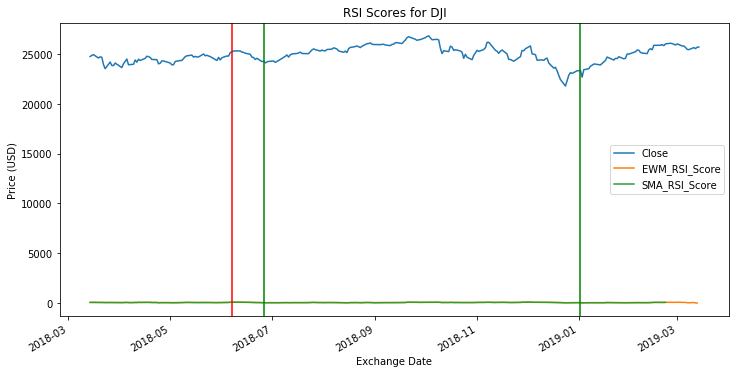

,End Date,Start Price,End Price,Start State,End State,ROI,False/True Signal,Portfolio Starting Value,Portfolio Ending Value
2018-06-07,2018-06-05,25241.41,24799.98,-1,0,0.017488,True,77612.06,77612.06


In [25]:
# THIS CELL RUNS FOR THE DJI DAILY FILE

import pandas
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

# Window length for RSI
window_length = 14
portfolio_value = 100000

#Geeting the dataset
dji = pd.DataFrame()
dji = pd.read_excel("{}.xlsx".format('DJI-daily'), skiprows=22,usecols=[0, 1],index_col=0)
dji['ROI'] = dji['Close'] / dji['Close'].shift(periods=-1) - 1

# Adjusted closing price of the stock
close = dji['Close']

# Get the ROI 
roi = close.diff()
roi = roi[1:] 

# Separate positive and negative ROI values
positive_dji = roi.copy()
negative_dji = roi.copy()
positive_dji[positive_dji < 0] = 0
negative_dji[negative_dji > 0] = 0

# Calculate the Exponential Moving Average on positive and negative ROI
ewm_positive = positive_dji.ewm(span = window_length).mean()
ewm_negative = (negative_dji.abs()).ewm(span = window_length).mean()

# Calculate the RSI based on  Exponential Moving Average
ewm_RSI = ewm_positive / ewm_negative
ewm_rsi_score = 100.0 - (100.0 / (1.0 + ewm_RSI))

# Calculate the Simple Moving Average on positive and negative ROI
sma_positive = positive_dji.rolling(window=window_length).mean()
sma_negative = (negative_dji.abs()).rolling(window=window_length).mean()

# Calculate the RSI based on Simple Moving Average
sma_RSI = sma_positive / sma_negative
sma_rsi_score = 100.0 - (100.0 / (1.0 + sma_RSI))

# Sellsignal, Buysignal calculations based on EWM RSI only
dji['EWM_RSI_Score']= ewm_rsi_score
dji['SMA_RSI_Score']= sma_rsi_score
dji['Sell_calc'] = ewm_rsi_score - 70
dji['Buy_calc'] = ewm_rsi_score - 30
dji['Sellsignal'] = 0
dji['Buysignal'] = 0
dji['Exitsignal'] = 0
dji['State'] = 0

# ExitSignal for RSI happens when RSI score drops below 50 as per 
# https://www.dailyfx.com/forex/education/trading_tips/daily_trading_lesson/2018/05/10/3-trading-tips-for-RSI.html
for i in range(0, len(dji)):
    if (dji['EWM_RSI_Score'].iloc[i] < 50):
        dji['Exitsignal'].iloc[i] = 1

# Sell signal calculations
for i in range(0, len(dji)):
    if (dji['Sell_calc'].iloc[i] < 0):
        if (dji['Sell_calc'].iloc[i-1] > 0):
            if (dji['Sell_calc'].iloc[i-2] > 0):
                if (dji['Sell_calc'].iloc[i-3] > 0):
                    if (dji['Sell_calc'].iloc[i-4] > 0):  
                        if (dji['Sell_calc'].iloc[i-5] > 0): 
                            dji['Sellsignal'].iloc[i] = 1


#Buysignal calculations
for i in range(0, len(dji)):
    if (dji['Buy_calc'].iloc[i] > 0):
        if (dji['Buy_calc'].iloc[i-1] < 0):
            if (dji['Buy_calc'].iloc[i-2] < 0):
                if (dji['Buy_calc'].iloc[i-3] < 0):
                    if (dji['Buy_calc'].iloc[i-4] < 0):  
                        if (dji['Buy_calc'].iloc[i-5] < 0):  
                            dji['Buysignal'].iloc[i] = 1
        
# STATE

# As confirmed with the TA:
# If there is no buy, sell or exit signal, the state should be maintained (stay the same as the state in the previous period).
# If in a long position and there's a buy signal, go into more long positions. 
# If in a long position and there's a sell signal, sell the long position and go into a short position.
# If in a short position and there's a buy signal, sell the short positions and go into a long position. 
# If in a short position and there's a sell signal, buy more short positions. 
# If in a short or long position and there's an exit signal, sell the positions. 

for i in range(1, len(dji)):
    
#     maintain state
    if(dji['Sellsignal'].iloc[i]==0 and dji['Buysignal'].iloc[i]==0 and dji['Exitsignal'].iloc[i]==0):
        dji['State'].iloc[i]= dji['State'].iloc[i-1]
    
#     buysignal
    if(dji['Buysignal'].iloc[i]==1 and (dji['State'].iloc[i-1]==1 or dji['State'].iloc[i-1]==0)):
        # if you were long and you get a buy signal, buy more long positions
        # if you were neutral and you get a buy signal, buy long positions
        dji['State'].iloc[i]=1
    if(dji['Buysignal'].iloc[i]==1 and dji['State'].iloc[i-1]==-1):
        # if prev state short and you get a buy sig, sell the short positions and buy long ones
        dji['State'].iloc[i]=1
        
#       sellsignal
    if(dji['Sellsignal'].iloc[i]==1 and dji['State'].iloc[i-1]==1):
         #if sellsignal 1 and previous state was long, sell the long position and buy short
        dji['State'].iloc[i]=-1
    if(dji['Sellsignal'].iloc[i]==1 and (dji['State'].iloc[i-1]==0 or dji['State'].iloc[i-1]==-1)):
        # if you were neutral and you get a sell signal, buy short positions
        # if you were short and get a sell signal, buy more short positions
        dji['State'].iloc[i]=-1

#        exit signal 
    if(dji['Exitsignal'].iloc[i]==1):
        dji['State'].iloc[i]= 0
    

    
# Filtering Exit Signals
dji['ExitsignalFinal'] = 0

for i in range(1, len(dji)):
    
    if(dji['State'].iloc[i] != dji['State'].iloc[i-1] and dji['State'].iloc[i]==0):
        dji['ExitsignalFinal'].iloc[i]=1
        
# Calculating Shares and Portfolio Value
dji['Shares'] = 0

dji['Portfolio Value'] = 0
share_num = 1

for i in range(1, len(dji)):
    
    if((dji['Buysignal'].iloc[i] == 0) and (dji['Sellsignal'].iloc[i] ==0) and (dji['Exitsignal'].iloc[i] ==0)):
        dji['Shares'].iloc[i]= dji['Shares'].iloc[i-1]
    
    #buy condition when long or no position
    if(dji['Buysignal'].iloc[i] ==1 and ((dji['State'].iloc[i-1] == 1) or (dji['State'].iloc[i-1] == 0))):
        shares_afford_long = portfolio_value/dji['Close'].iloc[i]
        if (shares_afford_long >= share_num):
            # if you can afford 10 shares, buy 10
            dji['Shares'].iloc[i]= dji['Shares'].iloc[i-1] + share_num
            portfolio_value = portfolio_value - (dji['Close'].iloc[i]*share_num)
#         else:
#             # if you can't afford 10 shares, buy as many as you can afford
#             dji['Shares'].iloc[i]= dji['Shares'].iloc[i-1] + shares_afford_long
#             portfolio_value = portfolio_value - (dji['Close'].iloc[i]*shares_afford_long)
    dji['Portfolio Value'].iloc[i] = portfolio_value
    
    #buy condition when short 
    if((dji['Buysignal'].iloc[i] ==1) and (dji['State'].iloc[i-1] == -1)):
        # Selling all short positions, so number of shares becomes 0
        portfolio_value = portfolio_value + dji['Shares'].iloc[i-1]*dji['Close'].iloc[i]
        dji['Shares'].iloc[i] = 0

        shares_afford_long = portfolio_value/dji['Close'].iloc[i]
        if (shares_afford_long >= share_num):
            # if you can afford 10 shares, buy 10
            dji['Shares'].iloc[i]= share_num
            portfolio_value = portfolio_value - (dji['Close'].iloc[i]*share_num)
#         else:
#             # if you can't afford 10 shares, buy as many as you can afford
#             dji['Shares'].iloc[i]= shares_afford_long
#             portfolio_value = portfolio_value - (dji['Close'].iloc[i]*shares_afford_long)
    dji['Portfolio Value'].iloc[i] = portfolio_value

    # sell condition when long
    if((dji['Sellsignal'].iloc[i] ==1) and dji['State'].iloc[i-1] == 1):
        
        # Selling all short positions, so number of shares becomes 0
        portfolio_value = portfolio_value - dji['Shares'].iloc[i-1]*dji['Close'].iloc[i]
        dji['Shares'].iloc[i] = 0

        shares_afford_short = portfolio_value/dji['Close'].iloc[i]
        if (shares_afford_short >= share_num):
            # if you can afford 10 shares, buy 10

            dji['Shares'].iloc[i]= - share_num
            portfolio_value = portfolio_value + share_num*dji['Close'].iloc[i]
#         else:
#             # if you can't afford 10 shares, buy as many as you can afford
#             dji['Shares'].iloc[i]= - shares_afford_short
#             portfolio_value = portfolio_value + shares_afford_short*dji['Close'].iloc[i]
    dji['Portfolio Value'].iloc[i] = portfolio_value
    
    # sell condition when short or no position
    if((dji['Sellsignal'].iloc[i] ==1) and ((dji['State'].iloc[i-1] == -1) or (dji['State'].iloc[i-1] == 0))):
        shares_afford_short = portfolio_value / dji['Close'].iloc[i]
        if (shares_afford_short >= share_num):
            # if you can afford 10 shares, buy 10
            dji['Shares'].iloc[i]= dji['Shares'].iloc[i-1]-share_num
            portfolio_value = portfolio_value + share_num*dji['Close'].iloc[i]
#         else:
#             # if you can't afford 10 shares, buy as many as you can afford
#             dji['Shares'].iloc[i]= dji['Shares'].iloc[i-1]-shares_afford_short
#             portfolio_value = portfolio_value + shares_afford_short*dji['Close'].iloc[i]
    dji['Portfolio Value'].iloc[i] = portfolio_value

                
    # exit condition
    if(dji['ExitsignalFinal'].iloc[i] ==1 and dji['State'].iloc[i-1] == 1):
        portfolio_value = portfolio_value + dji['Shares'].iloc[i-1]*dji['Close'].iloc[i]
        dji['Shares'].iloc[i]= 0
    dji['Portfolio Value'].iloc[i] = portfolio_value
        
    if(dji['ExitsignalFinal'].iloc[i] ==1 and dji['State'].iloc[i-1] == -1):
        portfolio_value = portfolio_value + dji['Shares'].iloc[i-1]*dji['Close'].iloc[i]
        dji['Shares'].iloc[i]= 0
    dji['Portfolio Value'].iloc[i] = portfolio_value


# summary statistics
stat_summary = pd.DataFrame(columns=['Price','State'])
for i in range(1, len(dji)):
    if (dji['State'].iloc[i] != dji['State'].iloc[i-1]):   
        
        
        if(dji['State'].iloc[i] == -dji['State'].iloc[i-1]):
            temp_df = pd.DataFrame({'Price':dji['Close'].iloc[i],'State':dji['State'].iloc[i]}, index=[dji.index[i]])
            stat_summary = stat_summary.append(temp_df)
            stat_summary = stat_summary.append(temp_df)
            
        else:
            temp_df = pd.DataFrame({'Price':dji['Close'].iloc[i],'State':dji['State'].iloc[i]}, index=[dji.index[i]])
            stat_summary = stat_summary.append(temp_df)
            
        
        
stat_summary['ROI'] = 0
stat_summary['False/True Signal'] = False
# entering position price
start = stat_summary['Price'].iloc[::2]
# leaving position price
end = stat_summary['Price'].iloc[1::2]

stat_summary['Portfolio Value']=0
stat_summary['Shares']=0

# calculate ROI
calc_roi = []
for i in range(0,len(start)):
    calc_roi.append((end[i]-start[i])/start[i])
    
calc_roi = pd.Series(calc_roi)

roi_index = 0
for test in range(1,len(stat_summary),2):
    if(stat_summary['State'].iloc[test-1] == -1):
        stat_summary['ROI'].iloc[test] = -1*calc_roi[roi_index]
    else: 
        stat_summary['ROI'].iloc[test] = calc_roi[roi_index]
    roi_index += 1

roi_index = 0
for test in range(1,len(stat_summary),2):    
    stat_summary['False/True Signal'].iloc[test-1] = ''
    if (stat_summary['ROI'].iloc[test] > 0): 
        stat_summary['False/True Signal'].iloc[test] = True
    roi_index += 1

for test in range(0,len(stat_summary),2):
    date_val = stat_summary.index[test]
    stat_summary['Portfolio Value'].iloc[test] = dji['Portfolio Value'].loc[date_val]
    stat_summary['Portfolio Value'].iloc[test+1] = dji['Portfolio Value'].loc[date_val]
    


stat_summary_final = pd.DataFrame(columns=['End Date','Start Price','End Price','Start State', 'End State', 'ROI', 'False/True Signal','Portfolio Starting Value', 'Portfolio Ending Value'])
stat_summary_final

for i in range(1,len(stat_summary),2):
    temp_df = pd.DataFrame({'End Date': stat_summary.index[i], 'Start Price': stat_summary['Price'].iloc[i-1],'End Price': stat_summary['Price'].iloc[i],'Start State': stat_summary['State'].iloc[i-1],'End State': stat_summary['State'].iloc[i], 'ROI': stat_summary['ROI'].iloc[i], 'False/True Signal': stat_summary['False/True Signal'].iloc[i], 'Portfolio Starting Value': stat_summary['Portfolio Value'].iloc[i-1], 'Portfolio Ending Value':stat_summary['Portfolio Value'].iloc[i]}, index=[stat_summary.index[i-1]])
    stat_summary_final = stat_summary_final.append(temp_df)

stat_summary_final = stat_summary_final[['End Date','Start Price','End Price','Start State', 'End State', 'ROI', 'False/True Signal','Portfolio Starting Value','Portfolio Ending Value']]    


# df_trades dataframe
df_trades = stat_summary.copy()

df_trades['Position'] = ''
for i in range(0, len(df_trades),2):
    df_trades['Position'].iloc[i]='Entering'
    df_trades['Position'].iloc[i+1]='Exiting'
    df_trades['Shares'].iloc[i+1]=''
            

# Outputting to csv
dji.to_csv('RSI-dji-daily-exitSignalUsingEMA.csv')

%matplotlib inline
# Plotting

dji_new = dji.copy()
# dji_new['New Date'] = datetime.datetime.strptime(dji_new.index[0], '%d-%m-%Y')

# for i in range(len(dji_new)):
#     dji_new['New Date'][i] = datetime.datetime.strptime(dji_new.index[i], '%d-%m-%Y')

# # dji_new = dji_new.reset_index(drop=True)
# dji_new = dji_new.reindex(dji_new['New Date'])
Axes = dji_new[['Close', 'EWM_RSI_Score', 'SMA_RSI_Score']].plot(figsize=(12,6))

# dji[['Close', 'BB_Middle', 'BB_Upper', 'BB_Lower']].plot(figsize=(12,6))
Axes.set_title('RSI Scores for DJI')
Axes.set_ylabel('Price (USD)')

sells = []
buys = []
for i in range(1, len(dji_new)):
    if(dji_new['Sellsignal'].iloc[i]==1):
        sells.append(dji_new.index[i])
    if(dji_new['Buysignal'].iloc[i]==1):
        buys.append(dji_new.index[i])
        
for s in sells:
    # short entry point is red
    Axes.axvline(x=s,color='r')

for b in buys:
    # long entry point is green
    Axes.axvline(x=b,color='g')
    
plt.show()

stat_summary_final

In [24]:
portfolio_value

-170387.74

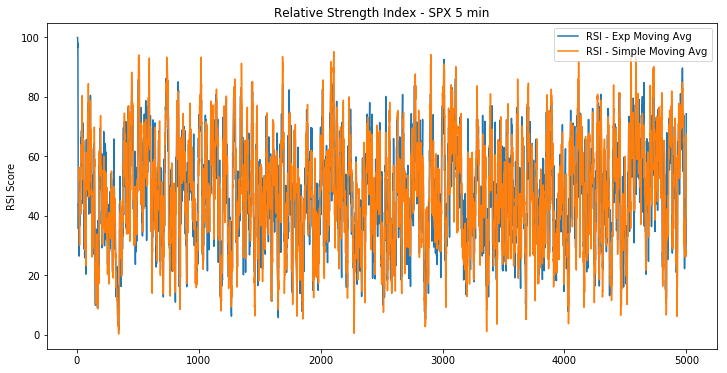

In [19]:
# THIS CELL RUNS FOR THE SPX 5 MIN FILE

import pandas
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

# Window length for RSI
window_length = 14

#Geeting the dataset
spx = pd.DataFrame()
spx = pd.read_excel("{}.xlsx".format('SPX-5min'), skiprows=13,usecols=[2])
spx['Close'] = spx
spx['ROI'] = spx['Close'] / spx['Close'].shift(periods=-1) - 1

# Adjusted closing price of the stock
close = spx['Close']

# Get the ROI 
roi = close.diff()
roi = roi[1:] 

# Separate positive and negative ROI values
positive_spx = roi.copy()
negative_spx = roi.copy()
positive_spx[positive_spx < 0] = 0
negative_spx[negative_spx > 0] = 0

# Calculate the Exponential Moving Average on positive and negative ROI
ewm_positive = positive_spx.ewm(span = window_length).mean()
ewm_negative = (negative_spx.abs()).ewm(span = window_length).mean()

# Calculate the RSI based on  Exponential Moving Average
ewm_RSI = ewm_positive / ewm_negative
ewm_rsi_score = 100.0 - (100.0 / (1.0 + ewm_RSI))

# Calculate the Simple Moving Average on positive and negative ROI
sma_positive = positive_spx.rolling(window=window_length).mean()
sma_negative = (negative_spx.abs()).rolling(window=window_length).mean()

# Calculate the RSI based on Simple Moving Average
sma_RSI = sma_positive / sma_negative
sma_rsi_score = 100.0 - (100.0 / (1.0 + sma_RSI))

# Compare graphically
%matplotlib inline
plt.figure()
ewm_rsi_score.plot(figsize=(12,6))
sma_rsi_score.plot(figsize=(12,6))
plt.legend(['RSI - Exp Moving Avg', 'RSI - Simple Moving Avg'])
plt.title('Relative Strength Index - SPX 5 min')
plt.ylabel('RSI Score')
plt.show()

# Sellsignal, Buysignal calculations based on EWM RSI only
spx['Sell_calc'] = ewm_rsi_score - 70
spx['Buy_calc'] = ewm_rsi_score - 30
spx['Sellsignal'] = 0
spx['Buysignal'] = 0


for i in range(0, len(spx)):
    if (spx['Sell_calc'].iloc[i] < 0):
        if (spx['Sell_calc'].iloc[i-1] > 0):
            if (spx['Sell_calc'].iloc[i-2] > 0):
                if (spx['Sell_calc'].iloc[i-3] > 0):
                    if (spx['Sell_calc'].iloc[i-4] > 0):  
                        if (spx['Sell_calc'].iloc[i-5] > 0): 
                            spx['Sellsignal'].iloc[i] = 1


for i in range(0, len(spx)):
    if (spx['Sellsignal'].iloc[i] != 1):
        spx['Sellsignal'].iloc[i] = 0

for i in range(0, len(spx)):
    if (spx['Buy_calc'].iloc[i] > 0):
        if (spx['Buy_calc'].iloc[i-1] < 0):
            if (spx['Buy_calc'].iloc[i-2] < 0):
                if (spx['Buy_calc'].iloc[i-3] < 0):
                    if (spx['Buy_calc'].iloc[i-4] < 0):  
                        if (spx['Buy_calc'].iloc[i-5] < 0):  
                            spx['Buysignal'].iloc[i] = 1


for i in range(0, len(spx)):
    if (spx['Buysignal'].iloc[i] != 1):
        spx['Buysignal'].iloc[i] = 0

spx.to_csv('spx_test.csv')

In [1]:
# THIS CELL RUNS FOR THE AAPL DAILY FILE

import pandas
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

# Window length for RSI
window_length = 14

portfolio_value = 100000

#Geeting the dataset
aapl = pd.DataFrame()
aapl = pd.read_csv("AAPL.csv", usecols=[0, 5],index_col=0)
aapl['Close'] = aapl
aapl['ROI'] = aapl['Close'] / aapl['Close'].shift(periods=-1) - 1

# Adjusted closing price of the stock
close = aapl['Close']

# Get the ROI 
roi = close.diff()
roi = roi[1:] 

# Separate positive and negative ROI values
positive_aapl = roi.copy()
negative_aapl = roi.copy()
positive_aapl[positive_aapl < 0] = 0
negative_aapl[negative_aapl > 0] = 0

# Calculate the Exponential Moving Average on positive and negative ROI
ewm_positive = positive_aapl.ewm(span = window_length).mean()
ewm_negative = (negative_aapl.abs()).ewm(span = window_length).mean()

# Calculate the RSI based on  Exponential Moving Average
ewm_RSI = ewm_positive / ewm_negative
ewm_rsi_score = 100.0 - (100.0 / (1.0 + ewm_RSI))

# Calculate the Simple Moving Average on positive and negative ROI
sma_positive = positive_aapl.rolling(window=window_length).mean()
sma_negative = (negative_aapl.abs()).rolling(window=window_length).mean()

# Calculate the RSI based on Simple Moving Average
sma_RSI = sma_positive / sma_negative
sma_rsi_score = 100.0 - (100.0 / (1.0 + sma_RSI))


# Sellsignal, Buysignal calculations based on EWM RSI only
aapl['EWM_RSI_Score']= ewm_rsi_score
aapl['SMA_RSI_Score']= sma_rsi_score
aapl['Sell_calc'] = ewm_rsi_score - 70
aapl['Buy_calc'] = ewm_rsi_score - 30
aapl['Sellsignal'] = 0
aapl['Buysignal'] = 0
aapl['Exitsignal'] = 0
aapl['State'] = 0

# ExitSignal for RSI happens when RSI score drops below 50 as per 
# https://www.dailyfx.com/forex/education/trading_tips/daily_trading_lesson/2018/05/10/3-trading-tips-for-RSI.html
for i in range(0, len(aapl)):
    if (aapl['EWM_RSI_Score'].iloc[i] < 50):
        aapl['Exitsignal'].iloc[i] = 1


# Sell signal calculations
for i in range(0, len(aapl)):
    if (aapl['Sell_calc'].iloc[i] < 0):
        if (aapl['Sell_calc'].iloc[i-1] > 0):
            if (aapl['Sell_calc'].iloc[i-2] > 0):
                if (aapl['Sell_calc'].iloc[i-3] > 0):
                    if (aapl['Sell_calc'].iloc[i-4] > 0):  
                        if (aapl['Sell_calc'].iloc[i-5] > 0): 
                            aapl['Sellsignal'].iloc[i] = 1


#Buysignal calculations
for i in range(0, len(aapl)):
    if (aapl['Buy_calc'].iloc[i] > 0):
        if (aapl['Buy_calc'].iloc[i-1] < 0):
            if (aapl['Buy_calc'].iloc[i-2] < 0):
                if (aapl['Buy_calc'].iloc[i-3] < 0):
                    if (aapl['Buy_calc'].iloc[i-4] < 0):  
                        if (aapl['Buy_calc'].iloc[i-5] < 0):  
                            aapl['Buysignal'].iloc[i] = 1
        
# STATE

# As confirmed with the TA:
# If there is no buy, sell or exit signal, the state should be maintained (stay the same as the state in the previous period).
# If in a long position and there's a buy signal, go into more long positions. 
# If in a long position and there's a sell signal, sell the long position and go into a short position.
# If in a short position and there's a buy signal, sell the short positions and go into a long position. 
# If in a short position and there's a sell signal, buy more short positions. 
# If in a short or long position and there's an exit signal, sell the positions. 

for i in range(1, len(aapl)):
    
#     maintain state
    if(aapl['Sellsignal'].iloc[i]==0 and aapl['Buysignal'].iloc[i]==0 and aapl['Exitsignal'].iloc[i]==0):
        aapl['State'].iloc[i]= aapl['State'].iloc[i-1]
    
#     buysignal
    if(aapl['Buysignal'].iloc[i]==1 and (aapl['State'].iloc[i-1]==1 or aapl['State'].iloc[i-1]==0)):
        # if you were long and you get a buy signal, buy more long positions
        # if you were neutral and you get a buy signal, buy long positions
        aapl['State'].iloc[i]=1
    if(aapl['Buysignal'].iloc[i]==1 and aapl['State'].iloc[i-1]==-1):
        # if prev state short and you get a buy sig, sell the short positions and buy long ones
        aapl['State'].iloc[i]=1
        
#       sellsignal
    if(aapl['Sellsignal'].iloc[i]==1 and aapl['State'].iloc[i-1]==1):
         #if sellsignal 1 and previous state was long, sell the long position and buy short
        aapl['State'].iloc[i]=-1
    if(aapl['Sellsignal'].iloc[i]==1 and (aapl['State'].iloc[i-1]==0 or aapl['State'].iloc[i-1]==-1)):
        # if you were neutral and you get a sell signal, buy short positions
        # if you were short and get a sell signal, buy more short positions
        aapl['State'].iloc[i]=-1

#        exit signal 
    if(aapl['Exitsignal'].iloc[i]==1):
        aapl['State'].iloc[i]= 0
    

    
# Filtering Exit Signals
aapl['ExitsignalFinal'] = 0

for i in range(1, len(aapl)):
    
    if(aapl['State'].iloc[i] != aapl['State'].iloc[i-1] and aapl['State'].iloc[i]==0):
        aapl['ExitsignalFinal'].iloc[i]=1
        
# Calculating Shares and Portfolio Value
aapl['Shares'] = 0

aapl['Portfolio Value'] = 0
share_num = 20

for i in range(1, len(aapl)):
    
    if((aapl['Buysignal'].iloc[i] == 0) and (aapl['Sellsignal'].iloc[i] ==0) and (aapl['Exitsignal'].iloc[i] ==0)):
        aapl['Shares'].iloc[i]= aapl['Shares'].iloc[i-1]
    
    #buy condition when long or no position
    if(aapl['Buysignal'].iloc[i] ==1 and ((aapl['State'].iloc[i-1] == 1) or (aapl['State'].iloc[i-1] == 0))):
        shares_afford_long = portfolio_value/aapl['Close'].iloc[i]
        if (shares_afford_long >= share_num):
            # if you can afford 10 shares, buy 10
            aapl['Shares'].iloc[i]= aapl['Shares'].iloc[i-1] + share_num
            portfolio_value = portfolio_value - (aapl['Close'].iloc[i]*share_num)
        else:
            # if you can't afford 10 shares, buy as many as you can afford
            aapl['Shares'].iloc[i]= aapl['Shares'].iloc[i-1] + shares_afford_long
            portfolio_value = portfolio_value - (aapl['Close'].iloc[i]*shares_afford_long)
    aapl['Portfolio Value'].iloc[i] = portfolio_value
    
    #buy condition when short 
    if((aapl['Buysignal'].iloc[i] ==1) and (aapl['State'].iloc[i-1] == -1)):
        # Selling all short positions, so number of shares becomes 0
        portfolio_value = portfolio_value + aapl['Shares'].iloc[i-1]*aapl['Close'].iloc[i]
        aapl['Shares'].iloc[i] = 0

        shares_afford_long = portfolio_value/aapl['Close'].iloc[i]
        if (shares_afford_long >= share_num):
            # if you can afford 10 shares, buy 10
            aapl['Shares'].iloc[i]= share_num
            portfolio_value = portfolio_value - (aapl['Close'].iloc[i]*share_num)
        else:
            # if you can't afford 10 shares, buy as many as you can afford
            aapl['Shares'].iloc[i]= shares_afford_long
            portfolio_value = portfolio_value - (aapl['Close'].iloc[i]*shares_afford_long)
    aapl['Portfolio Value'].iloc[i] = portfolio_value

    # sell condition when long
    if((aapl['Sellsignal'].iloc[i] ==1) and aapl['State'].iloc[i-1] == 1):
        
        # Selling all short positions, so number of shares becomes 0
        portfolio_value = portfolio_value - aapl['Shares'].iloc[i-1]*aapl['Close'].iloc[i]
        aapl['Shares'].iloc[i] = 0

        shares_afford_short = portfolio_value/aapl['Close'].iloc[i]
        if (shares_afford_short >= share_num):
            # if you can afford 10 shares, buy 10

            aapl['Shares'].iloc[i]= - share_num
            portfolio_value = portfolio_value + share_num*aapl['Close'].iloc[i]
        else:
            # if you can't afford 10 shares, buy as many as you can afford
            aapl['Shares'].iloc[i]= - shares_afford_short
            portfolio_value = portfolio_value + shares_afford_short*aapl['Close'].iloc[i]
    aapl['Portfolio Value'].iloc[i] = portfolio_value
    
    # sell condition when short or no position
    if((aapl['Sellsignal'].iloc[i] ==1) and ((aapl['State'].iloc[i-1] == -1) or (aapl['State'].iloc[i-1] == 0))):
        shares_afford_short = portfolio_value / aapl['Close'].iloc[i]
        if (shares_afford_short >= share_num):
            # if you can afford 10 shares, buy 10
            aapl['Shares'].iloc[i]= aapl['Shares'].iloc[i-1]-10
            portfolio_value = portfolio_value + share_num*aapl['Close'].iloc[i]
        else:
            # if you can't afford 10 shares, buy as many as you can afford
            aapl['Shares'].iloc[i]= aapl['Shares'].iloc[i-1]-shares_afford_short
            portfolio_value = portfolio_value + shares_afford_short*aapl['Close'].iloc[i]
    aapl['Portfolio Value'].iloc[i] = portfolio_value

                
    # exit condition
    if(aapl['ExitsignalFinal'].iloc[i] ==1 and aapl['State'].iloc[i-1] == 1):
        portfolio_value = portfolio_value + aapl['Shares'].iloc[i-1]*aapl['Close'].iloc[i]
        aapl['Shares'].iloc[i]= 0
    aapl['Portfolio Value'].iloc[i] = portfolio_value
        
    if(aapl['ExitsignalFinal'].iloc[i] ==1 and aapl['State'].iloc[i-1] == -1):
        portfolio_value = portfolio_value + aapl['Shares'].iloc[i-1]*aapl['Close'].iloc[i]
        aapl['Shares'].iloc[i]= 0
    aapl['Portfolio Value'].iloc[i] = portfolio_value


# summary statistics
stat_summary = pd.DataFrame(columns=['Price','State'])
for i in range(1, len(aapl)):
    if (aapl['State'].iloc[i] != aapl['State'].iloc[i-1]):   
        
        
        if(aapl['State'].iloc[i] == -aapl['State'].iloc[i-1]):
            temp_df = pd.DataFrame({'Price':aapl['Close'].iloc[i],'State':aapl['State'].iloc[i]}, index=[aapl.index[i]])
            stat_summary = stat_summary.append(temp_df)
            stat_summary = stat_summary.append(temp_df)
            
        else:
            temp_df = pd.DataFrame({'Price':aapl['Close'].iloc[i],'State':aapl['State'].iloc[i]}, index=[aapl.index[i]])
            stat_summary = stat_summary.append(temp_df)
            
        
        
stat_summary['ROI'] = 0
stat_summary['False/True Signal'] = False
# entering position price
start = stat_summary['Price'].iloc[::2]
# leaving position price
end = stat_summary['Price'].iloc[1::2]

stat_summary['Portfolio Value']=0
stat_summary['Shares']=0

# calculate ROI
calc_roi = []
for i in range(0,len(start)):
    calc_roi.append((end[i]-start[i])/start[i])
    
calc_roi = pd.Series(calc_roi)

roi_index = 0
for test in range(1,len(stat_summary),2):
    if(stat_summary['State'].iloc[test-1] == -1):
        stat_summary['ROI'].iloc[test] = -1*calc_roi[roi_index]
    else: 
        stat_summary['ROI'].iloc[test] = calc_roi[roi_index]
    roi_index += 1

roi_index = 0
for test in range(1,len(stat_summary),2):    
    stat_summary['False/True Signal'].iloc[test-1] = ''
    if (stat_summary['ROI'].iloc[test] > 0): 
        stat_summary['False/True Signal'].iloc[test] = True
    roi_index += 1

for test in range(0,len(stat_summary),2):
    date_val = stat_summary.index[test]
    stat_summary['Portfolio Value'].iloc[test] = aapl['Portfolio Value'].loc[date_val]
    stat_summary['Portfolio Value'].iloc[test+1] = aapl['Portfolio Value'].loc[date_val]
    


stat_summary_final = pd.DataFrame(columns=['End Date','Start Price','End Price','Start State', 'End State', 'ROI', 'False/True Signal','Portfolio Starting Value', 'Portfolio Ending Value'])
stat_summary_final

for i in range(1,len(stat_summary),2):
    temp_df = pd.DataFrame({'End Date': stat_summary.index[i], 'Start Price': stat_summary['Price'].iloc[i-1],'End Price': stat_summary['Price'].iloc[i],'Start State': stat_summary['State'].iloc[i-1],'End State': stat_summary['State'].iloc[i], 'ROI': stat_summary['ROI'].iloc[i], 'False/True Signal': stat_summary['False/True Signal'].iloc[i], 'Portfolio Starting Value': stat_summary['Portfolio Value'].iloc[i-1], 'Portfolio Ending Value':stat_summary['Portfolio Value'].iloc[i]}, index=[stat_summary.index[i-1]])
    stat_summary_final = stat_summary_final.append(temp_df)

stat_summary_final = stat_summary_final[['End Date','Start Price','End Price','Start State', 'End State', 'ROI', 'False/True Signal','Portfolio Starting Value','Portfolio Ending Value']]    


# df_trades dataframe
df_trades = stat_summary.copy()

df_trades['Position'] = ''
for i in range(0, len(df_trades),2):
    df_trades['Position'].iloc[i]='Entering'
    df_trades['Position'].iloc[i+1]='Exiting'
    df_trades['Shares'].iloc[i+1]=''
            

# Outputting to csv
aapl.to_csv('RSI-aapl-daily-exitSignalUsingEMA.csv')

%matplotlib inline
# Plotting

aapl_new = aapl.copy()
aapl_new['New Date'] = datetime.datetime.strptime(aapl_new.index[0], '%Y-%m-%d')

for i in range(len(aapl_new)):
    aapl_new['New Date'][i] = datetime.datetime.strptime(aapl_new.index[i], '%Y-%m-%d')

# aapl_new = aapl_new.reset_index(drop=True)
aapl_new = aapl_new.reindex(aapl_new['New Date'])



Axes = aapl_new[['Close', 'EWM_RSI_Score']].plot(figsize=(12,6))

# aapl[['Close', 'BB_Middle', 'BB_Upper', 'BB_Lower']].plot(figsize=(12,6))
Axes.set_title('RSI Scores for AAPL')
Axes.set_ylabel('Price (USD)')


sells = []
buys = []
for i in range(1, len(aapl_new)):
    if(aapl_new['Sellsignal'].iloc[i]==1):
        sells.append(aapl_new.index[i])
    if(aapl_new['Buysignal'].iloc[i]==1):
        buys.append(aapl_new.index[i])
        
for s in sells:
    # short entry point is red
    Axes.axvline(x=s,color='r')

for b in buys:
    # long entry point is green
    Axes.axvline(x=b,color='g')
    
plt.show()

stat_summary_final

C:\Users\kavya\Anaconda2\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\kavya\Anaconda2\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
C:\Users\kavya\Anaconda2\lib\site-packages\ipykernel_launcher.py:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<Figure size 1200x600 with 1 Axes>

,End Date,Start Price,End Price,Start State,End State,ROI,False/True Signal,Portfolio Starting Value,Portfolio Ending Value
2017-01-31,2017-04-11,117.160492,137.333206,-1,0,-0.172180,False,102343.20984,102343.20984
2017-07-21,2017-07-28,146.312531,145.562775,-1,0,0.005124,True,106714.27782,106714.27782
2017-11-14,2017-11-15,168.084793,165.867737,-1,0,0.013190,True,108620.34593,108620.34593
2018-05-15,2018-06-15,184.351776,186.724884,-1,0,-0.012873,False,107450.05082,107450.05082
2018-09-06,2018-09-10,221.374847,216.641724,-1,0,0.021381,True,111934.10720,111934.10720
2019-02-07,2019-03-07,170.210007,172.500000,-1,0,-0.013454,False,109568.54416,109568.54416


In [2]:
portfolio_value

107843.54416